In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import string
from unidecode import unidecode
import emoji

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from xgboost import XGBClassifier


# import torchtext.vocab
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

## Data loading

In [2]:
file_train = 'train_spam.csv'

data_train_all = pd.read_csv(file_train)

In [3]:
texts_train_all = data_train_all['text'].to_list()
labels_all = data_train_all['text_type']
target_all = pd.Categorical(labels_all, categories=['ham', 'spam']).codes

## Формируем множество важных для классификации слов

### Формируем массивы со спамом и с хамом.

In [4]:
data_ham = data_train_all[data_train_all['text_type'] == 'ham']
data_spam = data_train_all[data_train_all['text_type'] == 'spam']

texts_ham = data_ham['text'].to_list()
texts_spam = data_spam['text'].to_list()

number_of_ham = len(texts_ham)
number_of_spam = len(texts_spam)

print(f"Число нормальных сообщений: {number_of_ham}")
print(f"Число спама: {number_of_spam}")

Число нормальных сообщений: 11469
Число спама: 4809


### Функции для препроцессинга

In [5]:
lemmatizer = WordNetLemmatizer()

tokenizer = TweetTokenizer()

ENGLISH_STOP_WORDS = set(stopwords.words('english'))

In [6]:
def to_lower(words):
    result = words.lower()
    return result


def remove_underscore(words):
    return re.sub(r'_', ' ', words)

def remove_punctuation(words):
    result = re.sub(r'[!"#%&\'()*+,-./:;<=>?@\[\]^`{|}~]', ' ', words) # everything except underscore and $
    return result


def replace_hyperlink(words, replace=' <HTTP> '):
    return re.sub(r'http(?:\S*|\b)', replace, words)

def remove_hyperlink(words):
    return replace_hyperlink(words, '')


def emoji_to_text(words):
    return emoji.demojize(words)

def replace_emoji(words,  replace=' <EMOJI> '):
    return emoji.replace_emoji(words, replace=replace)

def remove_emoji(words):
    return replace_emoji(words, '')


def replace_non_ascii_words(words, replace=' <NONASCII> '):
    pattern = r'\b[^\x00-\x7F]+\b'
    non_ascii_words = re.sub(pattern, replace, words)
    return non_ascii_words

def replace_non_ascii(words, replace=' <NONASCII> '):
    pattern = r'[^\x00-\x7F]'
    non_ascii_words = re.sub(pattern, replace, words)
    return non_ascii_words

def remove_non_ascii(words):
    # return words.encode('ascii', errors='ignore').decode('ascii')
    return unidecode(words)


def replace_number(words, replace=' <NUMBER> '):
    result = re.sub(r'\w*\d\w*', replace, words)
    return result

def remove_number(words):
    return replace_number(words, '')


def replace_currency(words, replace=' <CURRENCY> '):
    currency_pattern = r'[£$€₹]'
    return re.sub(currency_pattern, replace, words)

def remove_currency(words):
    return replace_currency(words, '')


def replace_tag(words, replace=' <TAG> '):
    return re.sub(r'\w*@\w*', replace, words)

def replace_exclamation(words, replace=' <EXCLAMATION> '):
    return re.sub(r'!', replace, words)

def replace_question(words, replace=' <QUESTION> '):
    return re.sub(r'\?', replace, words)

def replace_slash(words, replace=' <SLASH> '):
    return re.sub(r'/', replace, words)

def replace_colon(words, replace=' <COLON> '):
    return re.sub(r':', replace, words)


def remove_whitespace(words):
    return words.strip()

def replace_newline(words):
    return words.replace('\n', ' ')

def remove_stop_words(words):
    return [i for i in words if i not in ENGLISH_STOP_WORDS]

def word_lemmatizer(words):
    return [lemmatizer.lemmatize(s) for s in words]

In [7]:
def preprocess_pipeline(sentence, preprocess_utils=None):
    if preprocess_utils is None:
        preprocess_utils = [
            to_lower,
            replace_newline,
            remove_underscore,
            replace_hyperlink,
            replace_emoji,
            replace_non_ascii_words,
            replace_non_ascii,
            remove_non_ascii,
            remove_punctuation,
            remove_whitespace,
            tokenizer.tokenize,
            remove_stop_words,
            word_lemmatizer,
        ]
    for func in preprocess_utils:
        sentence = func(sentence)
    return sentence

In [8]:
preprocess_utils = [
    to_lower,
    replace_newline,
    replace_hyperlink,
    remove_underscore,
    replace_currency,
    replace_emoji,
    replace_non_ascii_words,
    replace_non_ascii,
    remove_non_ascii,
    replace_number,
    replace_tag,
    replace_exclamation,
    replace_question,
    replace_slash,
    replace_colon,
    remove_punctuation,
    remove_whitespace,
    tokenizer.tokenize,
    remove_stop_words,
    word_lemmatizer,
]

Токенизируем ham и spam

In [9]:
texts_ham_tokenized = [
    preprocess_pipeline(sent, preprocess_utils) for sent in texts_ham
]

texts_spam_tokenized = [
    preprocess_pipeline(sent, preprocess_utils) for sent in texts_spam
]

Строим словари и выделяем топ важных слов

In [10]:
def build_vocab(tokenized_sentences):
    counter = Counter()
    for sentence in tokenized_sentences:
        counter.update(sentence)
    return counter

ham_vocab = build_vocab(texts_ham_tokenized)
print(f'Len of ham vocab {len(ham_vocab)}')

spam_vocab = build_vocab(texts_spam_tokenized)
print(f'Len of spam vocab {len(spam_vocab)}')

Len of ham vocab 28363
Len of spam vocab 17229


In [11]:
def get_important_words(vocab, texts_number, threshold = 0.05):
    top_words = vocab.most_common()
    important_words = set()
    for word, count in top_words:
        w = count / texts_number
        if w >= threshold:
            important_words.add(word)
        else:
            break
    
    return important_words

ham_important_words = get_important_words(ham_vocab, number_of_ham)
spam_important_words = get_important_words(spam_vocab, number_of_spam)

print('Number of ham important words', len(ham_important_words))
print('Number of spam important words', len(spam_important_words))

Number of ham important words 63
Number of spam important words 74


In [12]:
important_words = ham_important_words.union(spam_important_words)
print('Number of all important words', len(important_words))

Number of all important words 110


Features:
- Number of characters in original sentences
- Number of words in preprocessed with keyword replacement and tokenized by words
- Number of varius keywords (EMOJI, NUMBER, NONASCII, AT, QUESTION, EXCLAMATION, COLON, SLASH, etc)
- Number of other important words

In [13]:
def featurize(texts, preprocess_utils, important_words):
    N_texts = len(texts)

    ### character length of text
    length_in_charactes = np.zeros((N_texts, 1))
    for i, text in enumerate(texts):
        length_in_charactes[i] = len(text)
    

    ### Word length of text
    texts_tokenized = [
        preprocess_pipeline(sent, preprocess_utils) for sent in texts
    ]

    length_in_words = np.zeros((N_texts, 1))

    for i, text in enumerate(texts_tokenized):
        length_in_words[i] = len(text)    # some can be zero!
    

    ### Important words count

    n_important_words = np.zeros((N_texts, len(important_words)))
    for i, text in enumerate(texts_tokenized):
        text_joined = ' '.join(text)
        for j, word in enumerate(important_words):
            n_important_words[i, j] = text_joined.count(word) / (length_in_words[i] + 0.00001)
    
    X = np.hstack([length_in_charactes, length_in_words, n_important_words])
    return X


In [14]:
X = featurize(texts_train_all, preprocess_utils, important_words)
y = target_all

In [15]:
X_train, X_val, y_train, y_val = train_test_split(
                                    X, y,
                                    shuffle=True,
                                    random_state=42, 
                                    stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

Классы несбалансированы, но для оценки качества используется ROC AUC, который нечуствителен к дисбалансу. Поэтому каких-то дополнительных действий для борьбы с влиянием дисбаланса при подготовке данных и при обучении моделей делать не буду.

In [16]:
def calc_metrics(model, X_test, y_test):
    prob_pred = model.predict_proba(X_test)
    y_pred = np.argmax(prob_pred, axis=1)
    p_pred = prob_pred[:, 1]

    return (
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        roc_auc_score(y_test, p_pred)
    )

## Model 1: Logistic regression

In [190]:
params = {
    'C': np.logspace(0, 3, 6)
}

model = LogisticRegression(max_iter=10000, solver='saga', random_state=42)

grid = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

print(grid.best_params_)

(accuracy_val,
precision_val,
recall_val,
f1_val,
roc_auc_val) = calc_metrics(grid.best_estimator_, X_val, y_val)

print(f'Accuracy {accuracy_val:.4f}, Precision {precision_val:.4f}, ', end='')
print(f'Recall {recall_val:.4f}, f1 {f1_val:.4f}, ROC AUC {roc_auc_val:.5f}')

{'C': 1000.0}
Accuracy 0.8673, Precision 0.8111, Recall 0.7180, f1 0.7617, ROC AUC 0.94010


## Model 2: SVC

In [178]:
params = {
    'C': np.logspace(-1, 1, 3)
}

model = SVC(kernel='rbf', probability=True, random_state=42)

grid = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

print(grid.best_params_)

(accuracy_val,
precision_val,
recall_val,
f1_val,
roc_auc_val) = calc_metrics(grid.best_estimator_, X_val, y_val)

print(f'Accuracy {accuracy_val:.4f}, Precision {precision_val:.4f}, ', end='')
print(f'Recall {recall_val:.4f}, f1 {f1_val:.4f}, ROC AUC {roc_auc_val:.5f}')

{'C': 10.0}
Accuracy 0.9290, Precision 0.9087, Recall 0.8444, f1 0.8754, ROC AUC 0.97158


## Model 3: Random Forest

In [182]:
params = {
    'n_estimators': [50, 100, 500],
    'max_depth': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 3, 5, 10],
}

model = RandomForestClassifier(random_state=42)

grid = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

print(grid.best_params_)

(accuracy_val,
precision_val,
recall_val,
f1_val,
roc_auc_val) = calc_metrics(grid.best_estimator_, X_val, y_val)

print(f'Accuracy {accuracy_val:.4f}, Precision {precision_val:.4f}, ', end='')
print(f'Recall {recall_val:.4f}, f1 {f1_val:.4f}, ROC AUC {roc_auc_val:.5f}')

{'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 500}
Accuracy 0.9292, Precision 0.9561, Recall 0.7970, f1 0.8693, ROC AUC 0.97434


## Model 4: Gradient boosting

In [188]:
params = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 10, 15, 20],
    'learning_rate': np.logspace(-2, 0, 5)
}

model = XGBClassifier(n_estimators=500, seed=42, n_jobs=-1)

grid = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

print(grid.best_params_)

(accuracy_val,
precision_val,
recall_val,
f1_val,
roc_auc_val) = calc_metrics(grid.best_estimator_, X_val, y_val)

print(f'Accuracy {accuracy_val:.4f}, Precision {precision_val:.4f}, ', end='')
print(f'Recall {recall_val:.4f}, f1 {f1_val:.4f}, ROC AUC {roc_auc_val:.5f}')

{'learning_rate': 0.03162277660168379, 'max_depth': 10}
Accuracy 0.9408, Precision 0.9271, Recall 0.8677, f1 0.8964, ROC AUC 0.97969


## Model 5: Naive Bayes

In [189]:
model = GaussianNB()

model.fit(X_train, y_train)

(accuracy_val,
precision_val,
recall_val,
f1_val,
roc_auc_val) = calc_metrics(model, X_val, y_val)

print(f'Accuracy {accuracy_val:.4f}, Precision {precision_val:.4f}, ', end='')
print(f'Recall {recall_val:.4f}, f1 {f1_val:.4f}, ROC AUC {roc_auc_val:.5f}')

Accuracy 0.7071, Precision 0.5023, Recall 0.9251, f1 0.6511, ROC AUC 0.86016


### На данных фичах лучшим оказался градиентный бустинг на деревьях.

### Изобразим ROC для бустинга

In [17]:
model = XGBClassifier(n_estimators=500,
                      learning_rate=0.03162,
                      max_depth = 10,
                      seed=42,
                      n_jobs=-1)

model.fit(X_train, y_train)
prob_pred = model.predict_proba(X_val)
p_pred = prob_pred[:, 1]

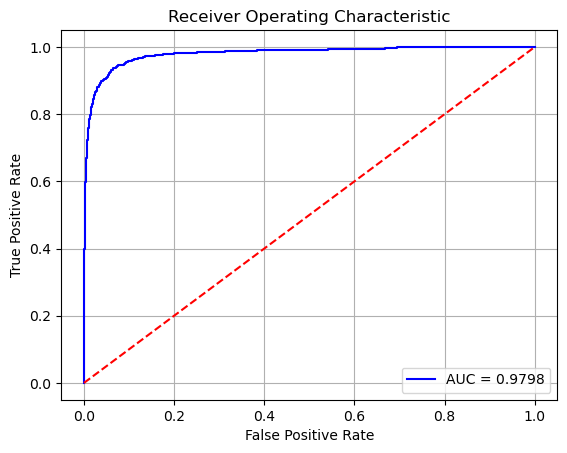

In [21]:
fpr, tpr, threshold = roc_curve(y_val, p_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = f'AUC = {roc_auc:0.4f}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()